In [4]:
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
from   sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from   skimage import io, transform
import os
from   tqdm import tqdm, trange


12712


Text(0.5, 1.0, 'Class Distribution')

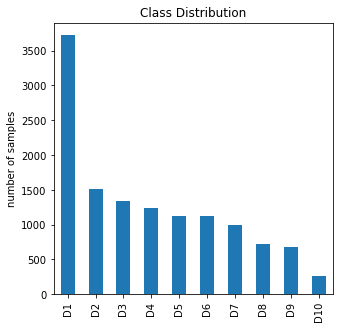

In [5]:
dataset = pd.read_csv('./Participants_Data_TLDCC/train.csv')
# dataset.head(10)
print(len(dataset))
plt.figure(figsize=(5,5))
dataset['Label'].value_counts().plot(kind='bar')
plt.xticks([0,1,2,3,4,5,6,7,8,9],["D1", "D2", "D3", "D4", "D5", "D6", "D7", "D8", "D9", "D10"])
plt.ylabel('number of samples')
plt.title("Class Distribution")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
default_params = {
    "batch_size_train": 64,
    "batch_size_test" : 100,
    "random_seed"     : 48,
    "learning_rate"   : 0.001,
    "momentum"        : 0.5
}

In [6]:
class LeafDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.dataset = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
        img_name = os.path.join(self.root_dir+self.dataset.iloc[index, 0])
        img = io.imread(img_name)
        label = self.dataset.iloc[index, 1]
#         label = np.array([label])
        if self.transform:
            img = self.transform(img)
        return img, label

In [7]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.ToPILImage(),
    torchvision.transforms.Resize(256),
    torchvision.transforms.Grayscale(3),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [8]:
leaf_dataset = LeafDataset("./Participants_Data_TLDCC/train.csv", 
                           './Participants_Data_TLDCC/train/',
                           transform=transformers)
test_data = LeafDataset("./Participants_Data_TLDCC/test.csv", 
                        './Participants_Data_TLDCC/test/', 
                        transform=transformers)

In [9]:
batch_size = 64
validation_split = .2
shuffle_dataset= True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(leaf_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

train_loader =    torch.utils.data.DataLoader(leaf_dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(leaf_dataset, batch_size=batch_size,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1)

In [10]:
def get_class_count(dataset):
    class_dict = {} 
    for img, label in dataset:
        class_dict[label] = class_dict.get(label, 0) + 1
    for label in class_dict.keys(): 
        print("Images belonging to " + str(label) + " are: " + str(class_dict[label]))

In [10]:
get_class_count(leaf_dataset)

Images belonging to 7 are: 1236
Images belonging to 4 are: 3719
Images belonging to 0 are: 1519
Images belonging to 9 are: 1122
Images belonging to 5 are: 678
Images belonging to 2 are: 1127
Images belonging to 1 are: 719
Images belonging to 8 are: 989
Images belonging to 3 are: 1335
Images belonging to 6 are: 268


In [13]:
%%time
import torch
import torchvision.models as models

model = models.resnet18().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
compiled_model = torch.compile(model)

x = torch.randn(16, 3, 224, 224)
optimizer.zero_grad()
out = compiled_model(x)
out.sum().backward()
optimizer.step()

AssertionError: Torch not compiled with CUDA enabled